In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))  # Move one level up to 'project_root'
from scripts.utilities import *

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.optimize as opt

### Evolution of Return Estimates: Mean and Variance Convergence for Newly Listed Stocks and ETFs

In [2]:
R = pd.read_csv('../data/returns.csv', index_col=0).iloc[:100]
R

,INCR,EURN,NRP,AUB,ROIV,RBA,SBGI,EBON,JCTCF,EXAS,...,PFC,GM,BOTJ,GROV,DRH,ODD,SITM,CPBI,VRTS,TEL
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.358566,0.009836,0.010309,0.100001,-0.042308,0.020711,-0.020725,-0.100000,0.000000,-0.041667,...,0.000000,0.002048,0.000000,0.015228,0.075472,0.051967,0.434615,-0.005495,-0.160952,-0.001287
3,-0.120235,-0.017857,-0.002551,-0.011364,-0.006024,0.037681,0.005291,0.051111,-0.031250,-0.021739,...,0.009091,-0.005254,0.000000,-0.015100,-0.017544,0.051200,-0.032172,0.000000,0.349603,-0.042525
4,-0.033333,0.016529,-0.025576,0.057472,0.001919,-0.027933,0.010526,-0.160677,0.000000,-0.004444,...,-0.009009,-0.024355,0.000000,0.000000,0.000000,-0.054985,-0.049861,0.002210,-0.138772,-0.012113
5,0.000000,-0.051219,0.004725,0.000000,0.008166,0.048850,-0.020833,0.100756,0.032258,0.000000,...,0.018182,0.006918,0.090909,0.000000,-0.013393,-0.027783,-0.008163,-0.007718,-0.032227,-0.020436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000000,0.004008,0.004349,-0.062761,0.000000,-0.004386,-0.029126,-0.108508,0.000000,-0.015018,...,0.008849,0.000000,0.000000,0.001028,-0.009523,0.069542,-0.043127,0.000000,0.014706,0.020178
97,0.000000,-0.015968,0.004764,0.017857,0.001019,-0.030837,0.015000,0.098202,0.000000,0.125561,...,-0.052632,-0.017037,0.000000,0.001541,-0.012238,-0.021125,-0.012676,0.002927,-0.026465,0.018034
98,-0.150000,-0.002704,0.007759,-0.017543,0.000000,-0.031818,-0.044335,-0.080605,0.000000,-0.066932,...,0.000000,-0.024451,0.000000,-0.004103,0.005309,-0.004765,-0.063718,-0.005837,-0.019417,0.019143
99,0.029412,-0.009492,-0.014115,0.071428,0.004073,-0.014084,0.000000,0.008219,0.000000,0.031597,...,-0.027778,-0.023794,-0.023809,0.001030,0.014965,0.063081,0.057389,0.001957,0.019142,-0.014017


# Descriptive part

In [3]:
# Melt the DataFrame to long format
df = to_long_format(R)
df

ret  const
i    t                   
INCR 2    0.154050    1.0
     3   -0.120235    1.0
     4   -0.033333    1.0
     5    0.000000    1.0
     6    0.017241    1.0
...            ...    ...
TEL  96   0.020178    1.0
     97   0.018034    1.0
     98   0.019143    1.0
     99  -0.014017    1.0
     100  0.005687    1.0

[541051 rows x 2 columns]

# Tests on mean

### $ R_{it} = \beta + \lambda_i + \gamma_t + u_{it} $ <- Fixed Effects model

**1. Common intercept:**

$$
\hat{\beta} = \bar{R}_{\cdot\cdot} = \frac{1}{NT} \sum_{i=1}^N \sum_{t=1}^T R_{it}
$$

**2. Asset fixed effects:**

$$
\hat{\lambda}_i = \bar{R}_{i\cdot} - \hat{\beta}
$$

**3. Time fixed effects:**

$$
\hat{\gamma}_t = \bar{R}_{\cdot t} - \hat{\beta}
$$

Which is alternative to: $ \hat{R}_{it} = \hat{\beta} + \sum_{i=0}^{N}(\hat{\lambda}_i \times D_i^{Asset}) + \sum_{t=0}^{T}(\hat{\gamma}_t \times D_t^{Time})$

---


$ H_0: \gamma_1 = \gamma_2 = \dots = \gamma_T = 0 $ \
$ H_a: \exists \gamma_t \neq 0 $ 

$ F = \frac{(RSS_r - RSS_u) / (df_r - df_u)}{s^2_{\text{HC3}}} \sim  \chi^2(T, n -p)$ 

Let:
$ \hat{u}_{it} = R_{it} - \hat{R}_{it}, \quad h_{it} = \text{leverage for observation } (i,t) $

$\hat{u}_{it,\text{HC3}} = \frac{\hat{u}_{it}}{1 - h_{it}} $

Then:
$ s^2_{\text{HC3}} = \frac{1}{n - p} \sum_{i,t} \left( \hat{u}_{it,\text{HC3}} \right)^2 $

$ \hat{R} = HR $ \
$ H = X (X'X)^{-1} X \to  h_{it} = x_{it} (X'X)^{-1} x_{it} $


First use Dummies approach to clearly calculate the significance of fixed effects under heteroskedasticity along time and asset (HC3 covariance estimation is used) \
Source: [MacKinnon, J. G. & White, H. (1985). “Some Heteroskedasticity‐Consistent Covariance Matrix Estimators with Improved Finite Sample Properties.” Journal of Econometrics, 29(3), 305–325.](https://www.econstor.eu/bitstream/10419/189084/1/qed_wp_0537.pdf)

In [4]:
# Reset index so 'i' and 't' are columns
df_dummy = df.reset_index()[:100000] ### Limit the F test to 100k rows

# Make dummies
A = pd.get_dummies(df_dummy['i'], prefix='A', drop_first=True).astype(float)
T = pd.get_dummies(df_dummy['t'], prefix='T', drop_first=True).astype(float)

# Baseline model: only constant
X_base = df_dummy[['const']].astype(float)
mod_base = sm.OLS(df_dummy['ret'].astype(float), X_base).fit()

# Entity-only model
X_ent = pd.concat([df_dummy[['const']], A], axis=1)
mod_ent  = sm.OLS(df_dummy['ret'], X_ent).fit() 

# Entity + Time model
X_enttime = pd.concat([df_dummy[['const']], A, T], axis=1)
mod_enttime = sm.OLS(df_dummy['ret'], X_enttime).fit()

# Compare baseline vs entity:
print("Baseline vs Entity-only:")
print(anova_lm(mod_base, mod_ent, robust='hc3'))

# Compare entity-only vs entity+time:
print("\nEntity-only vs Entity+Time:")
print(anova_lm(mod_ent, mod_enttime, robust='hc3'))

# Or compare all three at once:
print("\nAll three models:")
print(anova_lm(mod_base, mod_ent, mod_enttime, robust='hc3'))

print("\nR2:", mod_enttime.rsquared,"p-value:", mod_enttime.f_pvalue)

Baseline vs Entity-only:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0   99999.0  152.228191      0.0       NaN       NaN       NaN
1   98989.0  150.365288   1010.0  1.862904  1.214251  0.000003

Entity-only vs Entity+Time:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0   98989.0  150.365288      0.0       NaN       NaN       NaN
1   98891.0  150.108892     98.0  0.256396  1.723595  0.000012

All three models:
   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0   99999.0  152.228191      0.0       NaN       NaN       NaN
1   98989.0  150.365288   1010.0  1.862904  1.215121  0.000003
2   98891.0  150.108892     98.0  0.256396  1.723595  0.000012

R2: 0.013921858776226537 p-value: 8.683821487815363e-09


Both time and asset effects are significant at 5% \
Further on use Demeaning approach

In [5]:
# Entity + Time model
model = PanelOLS(df['ret'], df[['const']], entity_effects=True, time_effects=True).fit(cov_type="robust")
print(model.rsquared_inclusive)

0.01325572559383359


Retrieve the time component ($\gamma_t$)

In [6]:
gamma = model.estimated_effects.groupby('t').mean()['estimated_effects']
gamma

t
2      0.000605
3     -0.001007
4     -0.002245
5     -0.002611
6     -0.002660
         ...   
96     0.000845
97     0.000014
98    -0.000104
99    -0.000509
100   -0.001455
Name: estimated_effects, Length: 99, dtype: float64

Smooth gamma using Gaussian kernel regression

$$
\widehat f(x)
= \frac{\displaystyle\sum_{i=1}^n K_\sigma(x, x_i)\,y_i}
       {\displaystyle\sum_{i=1}^n K_\sigma(x, x_i)},
\quad
K_\sigma(x, x_i)
= \exp\!\biggl(-\frac{(x - x_i)^2}{2\sigma^2}\biggr).
$$

In [7]:
def gaus_kernel(x,xi,h):
    return np.exp(-0.5*(x-xi)**2/h**2)

def kd_regression(x, x_data, y_data, h):

    k_h = gaus_kernel(x, x_data, h)
    
    numerator = np.dot(y_data, k_h)
    denominator = np.sum(k_h)
    return numerator/denominator

# def exp_decay(x, A, k, C):
#     return A * np.exp(-k * x) + C


gamma_kernel = [kd_regression(ti, gamma.index, gamma.values, 5) for ti in gamma.index]
gamma_kernel = pd.Series(gamma_kernel, index = gamma.index)

# popt, pcov = curve_fit(exp_decay, gamma.index, gamma.values, p0=[1, 1, 1])
# y_exp = exp_decay(gamma.index, *popt)


In [8]:
fig_gamma = go.Figure()
fig_gamma.add_trace(go.Scatter(x=gamma.index, y=gamma.values, mode='markers', name='Raw Gamma'))
fig_gamma.add_trace(go.Scatter(x=gamma.index, y=gamma_kernel, mode='lines', name='Kernel Regression'))
# fig_gamma.add_trace(go.Scatter(x=gamma.index, y=y_exp, mode='lines', name='Exponential Fit'))
fig_gamma.show()

In [9]:
def cumul_mean(arr):
    cumul_mean = np.cumsum(arr, axis=0)    
    for i in range(cumul_mean.shape[0]):       
        if i == 0:
            continue        
        cumul_mean[i] =  cumul_mean[i] / (i + 1)
    return cumul_mean

In [10]:
fig_gamma_cumul = go.Figure()
fig_gamma_cumul.add_trace(go.Scatter(x=gamma.index, y=cumul_mean(gamma.values), mode='markers', name='Raw Gamma'))
fig_gamma_cumul.show()

number of lags: 0


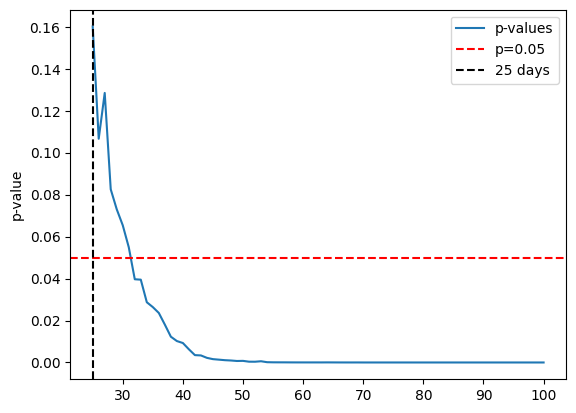

In [11]:
# Using expanding ADF test to see if gamma becomes stationary over time

lags = adfuller(gamma, autolag='AIC')[2]
print("number of lags:", lags)

pvals = []
q = 23
for i in range(q, len(gamma)):
    sample = gamma.iloc[:i]
    adf_p = adfuller(sample, maxlag=lags, autolag=None)[1]
    pvals.append(adf_p)

plt.plot(gamma.index[q:], pvals, label = 'p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='p=0.05')
plt.axvline(x=q + 2, color='r', linestyle='--', c = 'black', label=f'{q + 2} days')
plt.ylabel('p-value')
plt.legend()
plt.show()

In [12]:
adf_df = pd.Series(pvals, index=gamma.index[q:])
adf_df[adf_df < 0.05].index[0] # first time gamma becomes stationary

32

**ADF Test Hypotheses:**

$ H_0 : b = 0 $ (non-stationary, unit root present) \
$ H_a : b < 0 $ (stationary)

**Test Regression Equation:**

$$
\Delta y_t = a + b y_{t-1} + \sum_{i=1}^p c_i \Delta y_{t-i} + \varepsilon_t
$$

**Test Statistic:**

$$
\tau = \frac{\hat{\gamma}}{\text{SE}(\hat{\gamma})} \sim T^{\text{DF}}(\text{constant only, n})
$$
$$\mathrm{AIC} = \ln\!\left(\frac{\mathrm{RSS}}{n}\right) + \frac{\mathrm{2k}}{n}$$

# Tests on variance

### $ \begin{cases} Var(u_{it}) = k_i \times \sigma_t^2 \\ E(u_{it}) = 0 \end{cases}$

$ \hat u_{it} = R_{it} - \hat{R}_{it} $ \
$ E(\hat u_{it}) = 0 $ \
$ Var(\hat u_{it}) = k_i \times \sigma_t^2 = \hat u_{it}^2$

In [13]:
resids = df['ret'] - model.estimated_effects['estimated_effects'] - model.fitted_values['fitted_values']
resids = pd.DataFrame(resids, columns=['resid'])
resids

resid
i    t            
INCR 2    0.155114
     3   -0.117558
     4   -0.029419
     5    0.004280
     6    0.021571
...            ...
TEL  96   0.020093
     97   0.018780
     98   0.020007
     99  -0.012748
     100  0.007901

[541051 rows x 1 columns]


#### Modeled via Iterated Feasible Generalized Least Squares (IFGLS) -> [Source](https://www.jstor.org/stable/1909405?seq=1): 
$
\begin{aligned}
1.\quad &\hat u_{it} = R_{it} - \hat\beta - \hat\lambda_i - \hat\gamma_t, \\
2.\quad &\hat\sigma_t^2 \;=\;\frac{1}{N}\sum_{i=1}^N \hat u_{it}^2, \\
3.\quad &\hat k_i \;=\;\frac{1}{T}\sum_{t=1}^T \frac{\hat u_{it}^2}{\hat\sigma_t^2}, \\
4.\quad &\hat\sigma_t^2 \;=\;\frac{1}{N}\sum_{i=1}^N \frac{\hat u_{it}^2}{\hat k_i}, \\
5.\quad &\text{Repeat steps 3–4 until } 
\max\bigl|\hat k_i^{(r)}-\hat k_i^{(r-1)}\bigr|,\,
\max\bigl|\hat\sigma_t^{2\,(r)}-\hat\sigma_t^{2\,(r-1)}\bigr|<\varepsilon.
\end{aligned}
$

P. A. V. B. Swamy, and S. S. Arora. “The Exact Finite Sample Properties of the Estimators of Coefficients in the Error Components Regression Models.” Econometrica, vol. 40, no. 2, 1972, pp. 261–75. JSTOR, https://doi.org/10.2307/1909405. Accessed 27 Apr. 2025.


In [14]:
k, sigma = estimate_k_sigma(resids.reset_index())

Converged after 9 iterations.


In [15]:
sigma.min(), k.min()

### Both values >= 0 thus the model never predicts negative variance 

(0.8134401414876293, 7.030182470121779e-07)

In [16]:
sigma_kernel = [kd_regression(ti, sigma.index, sigma.values, 5) for ti in sigma.index]
sigma_kernel = pd.Series(sigma_kernel, index = sigma.index)

In [17]:
fig_sigma = go.Figure()
fig_sigma.add_trace(go.Scatter(x=sigma.index, y=sigma.values, mode='markers', name='Raw Sigma'))
fig_sigma.add_trace(go.Scatter(x=sigma.index, y=sigma_kernel, mode='lines', name='Kernel Regression'))
fig_sigma.show()

In [18]:
fig_sigma_cumul = go.Figure()
fig_sigma_cumul.add_trace(go.Scatter(x=sigma.index, y=cumul_mean(sigma.values), mode='markers', name='Raw sigma'))
fig_sigma_cumul.show()

number of lags: 8


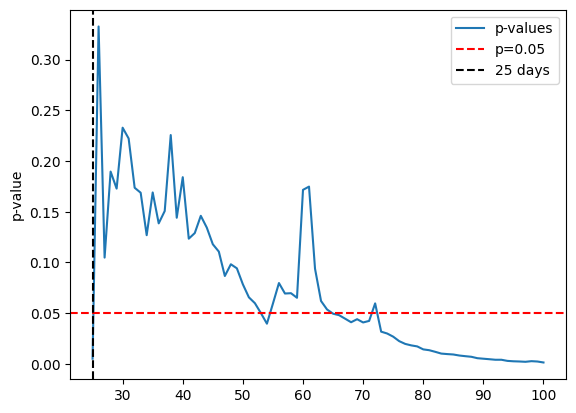

In [19]:
# Using expanding ADF test to see if sigma becomes stationary over time

lags = adfuller(sigma, autolag='AIC')[2]
print("number of lags:", lags)

pvals = []
q = 23
for i in range(q, len(sigma)):
    sample = sigma.iloc[:i]
    adf_p = adfuller(sample, maxlag=lags, autolag=None)[1]
    pvals.append(adf_p)

plt.plot(sigma.index[q:], pvals, label = 'p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='p=0.05')
plt.axvline(x=q + 2, color='r', linestyle='--', c = 'black', label=f'{q + 2} days')
plt.ylabel('p-value')
plt.legend()
plt.show()

In [20]:
resids_sq = (resids ** 2).rename(columns={'resid': 'Squared resid'})
resids_sq

Squared resid
i    t                 
INCR 2         0.024060
     3         0.013820
     4         0.000865
     5         0.000018
     6         0.000465
...                 ...
TEL  96        0.000404
     97        0.000353
     98        0.000400
     99        0.000163
     100       0.000062

[541051 rows x 1 columns]

### If indeed $ Var(u_{it}) = k_i \times \sigma_t^2 \Rightarrow  Var(\frac{u_{it}}{\sqrt{k_i} \times \sigma_t}) = 1 \Rightarrow E(\frac{u_{it}^2}{k_i \times \sigma_t^2}) = 1$, so the sample must be homoskedastic
### Let $ \frac{\hat{u}_{it}}{\sqrt{\hat{k}_i} \times \hat{\sigma}_t} = \hat{v}_{it} \Rightarrow \frac{\hat{u}_{it}^2}{\hat{k}_i \times \hat{\sigma}_t^2} = \hat{v}_{it}^2 $

To test for heteroskedasticity, use Breusch-Pagan test:

1. Estimate $\hat{v}_{it}$.

2. Regress the squared residuals on entity and time dummies to get an auxiliery equation:

$$
\hat{v}_{it}^2 = \alpha + \sum_{i=1}^{N-1} \delta_i \times D_i^{Asset} + \sum_{t=1}^{T-1} \theta_t \times D_t^{Time} + \varepsilon_{it},
$$

3. Compute the test statistic:

$$
stat = \#\text{Obs} \times R_{\text{aux}}^2,
$$

- $H_0$: homoskedasticity; $\delta_i = 0$ and $\theta_t = 0$ $\forall i, t $.

- $H_a$: heteroskedasticity; $\exists$ $\delta_i \ne 0$ or $\theta_t \ne 0$.

    Under the null hypothesis of homoskedasticity, $stat \sim \Chi^2(N + T - 2)$


In [21]:
rows = []
for (i,t) in resids_sq.index:
    rows.append(sigma[t] * k[i])

var_pred = pd.Series(rows, index=resids_sq.index)
std_pred = np.sqrt(var_pred)

In [22]:
v_sqr = resids_sq['Squared resid'] / var_pred

auxiliery = PanelOLS(v_sqr, df[['const']], entity_effects=True, time_effects=True).fit()
print("R2 (including fixed effects) is:", auxiliery.rsquared_inclusive)

chi_st = auxiliery.rsquared_inclusive * len(v_sqr)
print("p-value is:",stats.chi2.sf(chi_st, 0.5 * (R.index.nunique() - 1 + R.columns.nunique() - 1)))

R2 (including fixed effects) is: 0.0
p-value is: 1.0


### The sample is homoskedastic at 5% $\Rightarrow$ the variance prediction is satisfactory

<!-- ### $ Var(u_{it}) = \alpha \times k_i \times \sigma_t^2 $
### Model as: 
### $ \hat u_{it}^ 2 = e^{(\phi_0 + \sum_{i=0}^{N}(\phi_{1,i} \times D_i^{Asset}) + \sum_{t=0}^{T}(\phi_{2,t} \times D_t^{Time}) + \omega_{it})}$
### $ \log{u_{it}^ 2} = \phi_0 + \sum_{i=0}^{N}(\phi_{1,i} \times D_i^{Asset}) + \sum_{t=0}^{T}(\phi_{2,t} \times D_t^{Time}) + \omega_{it} $

### Then $ \hat{\alpha} = e^{\hat{\phi}_0}, \hat{k}_i = e^{\sum_{i=0}^{N}(\hat{\phi}_{1,i} \times D_i^{Asset})}, \hat{\sigma}_t^2 = e^{\sum_{t=0}^{T}(\hat{\phi}_{2,t} \times D_t^{Time})}$ -->

# Test for overall significance

For each asset check if GenNorm, LogNorm or Student T distributions are significantly good fit (p-val > 0.01) for the returns using KS-test

In [23]:
### Takes a while to run

# vals = {}
# empty = 0

# def check_gennorm_fit(data) -> float:
#     data = data.replace([np.inf, -np.inf], np.nan).dropna()
#     beta_hat, loc_hat, scale_hat = stats.gennorm.fit(data)
#     cdf_fitted = lambda x: stats.gennorm.cdf(x, beta_hat, loc=loc_hat, scale=scale_hat)
#     _, pval = stats.kstest(data, cdf_fitted)
#     return pval

# def check_lognorm_fit(data) -> float:
#     data = data.replace([np.inf, -np.inf], np.nan).dropna()
#     s_hat, loc_hat, scale_hat = stats.lognorm.fit(data)
#     cdf_fitted = lambda x: stats.lognorm.cdf(x, s_hat, loc=loc_hat, scale=scale_hat)
#     _, pval = stats.kstest(data, cdf_fitted)
#     return pval

# def check_t_fit(data: pd.Series) -> float:
#     data = data.replace([np.inf, -np.inf], np.nan).dropna()
#     df_hat, loc_hat, scale_hat = stats.t.fit(data)
#     cdf = lambda v: stats.t.cdf(v, df_hat, loc=loc_hat, scale=scale_hat)
#     _, pval = stats.kstest(data, cdf)
#     return pval

# for col in tqdm(R.columns):
#     x = R[col]
#     try:
#         pval_gennorm = check_gennorm_fit(x)
#         pval_lognorm = check_lognorm_fit(x)
#         pval_t = check_t_fit(x)
#         vals[col] = {'GenNorm': pval_gennorm, 'LogNorm': pval_lognorm, 'T': pval_t}
#     except: empty += 1

# dist_table = pd.DataFrame(vals)

# dist_table.T.sort_index().to_csv('../data/distribution_table.csv')

In [24]:
dist_table = pd.read_csv('../data/distribution_table.csv', index_col=0)
dist_table

,GenNorm,LogNorm,T
A,8.724509e-01,6.187192e-01,9.445423e-01
AA,7.159728e-01,6.417054e-01,5.799641e-01
AACG,9.778659e-01,2.376695e-02,8.724862e-01
AACI,1.685581e-03,5.192771e-07,4.144383e-04
AACT,3.023762e-07,2.060918e-04,5.078614e-04
...,...,...,...
ZVRA,8.337344e-01,4.534683e-01,9.112191e-01
ZVSA,2.830516e-13,1.490964e-13,1.475532e-19
ZWS,8.638181e-01,8.130364e-02,9.490471e-01
ZYME,9.499736e-01,4.051373e-01,8.712166e-01


In [25]:
print("Share that fits to GenNorm:", dist_table[dist_table['GenNorm'] > 0.01].shape[0] / len(dist_table))
print("Share that fits to LogNorm:", dist_table[dist_table['LogNorm'] > 0.01].shape[0] / len(dist_table))
print("Share that fits to T:", dist_table[dist_table['T'] > 0.01].shape[0] / len(dist_table))

Share that fits to GenNorm: 0.6445948417779404
Share that fits to LogNorm: 0.6638009877446497
Share that fits to T: 0.7274556429486007


### Further use Student's T as the distribution for LR test

In [26]:
LR_columns = dist_table[dist_table['T'] > 0.01].index.values
LR_sample = R[LR_columns]
LR_sample

,A,AA,AACG,AADI,AAGR,AAL,AAMC,AAN,AAOI,AAP,...,ZTO,ZTS,ZUMZ,ZUO,ZURA,ZVIA,ZVRA,ZWS,ZYME,ZYXI
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.082386,-0.021798,-0.028570,-0.022222,-0.003571,0.062176,-0.066667,-0.158491,0.014056,0.027857,...,0.025347,0.000323,-0.014475,0.030000,3.143646,0.008791,-0.008929,0.055000,0.005385,0.024823
3,0.089783,-0.019499,0.123528,0.079545,-0.000512,-0.014146,-0.044218,-0.139462,-0.009901,-0.033878,...,-0.003531,0.000645,-0.016728,0.000000,0.107000,0.000000,0.002252,0.029858,0.002295,0.003460
4,-0.090909,-0.022726,-0.004189,-0.035158,-0.001025,0.039585,0.015658,-0.040646,0.000000,-0.039904,...,-0.054932,-0.000322,0.006224,-0.050971,-0.114122,-0.044299,-0.005843,-0.008284,0.013740,-0.003448
5,0.026562,-0.005814,-0.001052,-0.018110,0.000000,0.023322,0.067274,-0.008691,-0.003000,0.108313,...,0.000000,0.031260,-0.030928,0.000512,-0.427600,-0.011398,-0.000904,-0.000928,-0.012801,-0.013841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.036765,-0.007812,0.010482,-0.033413,0.000406,0.039000,0.252837,0.002011,-0.021110,0.001633,...,-0.016794,-0.005773,-0.017129,0.051528,0.016077,0.058985,0.009784,-0.020806,-0.015796,0.014492
97,0.083172,-0.026246,0.009682,0.014815,-0.005076,0.052294,0.161833,0.025291,0.001597,0.018745,...,-0.014752,-0.026129,0.028233,-0.078632,0.037975,0.011658,0.023967,0.025232,-0.046914,-0.035713
98,0.161905,-0.008086,0.031507,0.038929,0.002041,0.028963,-0.040551,0.000391,0.116427,-0.002000,...,0.007880,0.013581,0.018644,0.032777,0.021341,0.093470,-0.001494,0.020078,-0.009067,-0.029630
99,-0.121926,-0.010870,-0.001992,-0.021077,-0.001018,-0.010963,-0.031596,-0.052838,-0.024286,0.022044,...,-0.022674,-0.007190,0.053577,0.018263,0.004478,0.023419,0.033416,-0.014603,0.036601,-0.061068


We want to test, for the whole sample, the null hypothesis that time effects are not significant:

$ H_0: R_{it} = \beta + \lambda_i + u_{it}; u_{it} \sim \text{Student}_{\nu}(0, k_i); \text{i.e}\ \gamma_t = 0 \ \text{and} \ \sigma_t^2 = 1 \ \forall $ \
$ H_a: R_{it} = \beta + \lambda_i + \gamma_t + u_{it}; u_{it} \sim \text{Student}_{\nu}(0, k_i\sigma_t^2); \text{i.e}\ \exists t: \gamma_t \neq 0\ \text{or}\ \sigma_t^2 \neq 1 $


We perform a likelihood ratio test, where:
- $\ell_1$ is the log-likelihood under the full model
- $\ell_0$ is the log-likelihood under the restricted model

The test statistic is:
$
\Lambda = -2\left( \ell_0 - \ell_1 \right),
$
which asymptotically follows a chi-squared distribution:
$
\Lambda \sim \chi^2_{2T-2},
$
where $T$ is the number of time periods. \
$ \text{df} = 2T - 2 $, as there are extra $(T - 1)$ estimators for mean and $(T-1)$ estimators for variance

In [27]:
beta = model.params['const']
gamma = model.estimated_effects.groupby('t').mean()['estimated_effects']
lambda_ = model.estimated_effects.groupby('i').mean()['estimated_effects']
k, sigma = estimate_k_sigma(resids.reset_index(), silent=True)

resids_unres = resids['resid'] / std_pred
resids_unres = resids_unres[resids_unres.index.get_level_values(0).isin(LR_columns)]
resids_unres

i     t  
INCR  2      1.486949
      3     -1.351996
      4     -0.354267
      5      0.050876
      6      0.266373
               ...   
TEL   96     1.217870
      97     1.107629
      98     1.202717
      99    -0.793659
      100    0.462366
Length: 393546, dtype: float64

In [28]:
model_res = PanelOLS(df['ret'], df[['const']], entity_effects=True, time_effects=False).fit()
beta_res = model_res.params['const']
lambda_res = model_res.estimated_effects.groupby('i').mean()['estimated_effects']
k_res = resids_sq.reset_index().groupby('i')['Squared resid'].mean()

resids_res = df['ret'] - model_res.estimated_effects['estimated_effects'] - model_res.fitted_values['fitted_values']
resids_res = resids_res / np.sqrt(k_res)
resids_res = resids_res[resids_res.index.get_level_values(0).isin(LR_columns)]
resids_res

i     t  
INCR  2      2.391991
      3     -1.821200
      4     -0.486339
      5      0.025683
      6      0.290522
               ...   
TEL   96     1.215140
      97     1.090689
      98     1.155059
      99    -0.769434
      100    0.374118
Length: 393546, dtype: float64

In [29]:
def fit_df_student_t(residuals):
    """
    Estimate degrees of freedom v for Student's t distribution via MLE
    given 1D array of residuals.
    """
    # negative log-likelihood
    def nll(v):
        if v <= 2:
            return np.inf
        return -np.sum(stats.t.logpdf(residuals, df=v, loc=0, scale=1))
    # initial guess
    result = minimize(nll, x0=5.0, bounds=[(2.1, 100)])
    return result.x[0]


def log_likelihood_student_t(residuals, v):
    """
    Compute log-likelihood of residuals under Student's t with df=v.
    Assumes zero mean and scale=1.
    """
    return np.sum(stats.t.logpdf(residuals, df=v, loc=0, scale=1))


def lr_test(unrestricted, restricted):

    assets = unrestricted.index.get_level_values(0).unique()
    times = unrestricted.index.get_level_values(1).unique()

    df_diff = 2 * len(times) - 2

    ll_unres = []
    ll_res = []

    for asset in tqdm(assets):
        # get residuals per asset
        res_u = unrestricted[unrestricted.index.get_level_values(0) == asset].values
        res_r = restricted[restricted.index.get_level_values(0) == asset].values

        # estimate v via MLE
        v_u = fit_df_student_t(res_u)
        v_r = fit_df_student_t(res_r)

        # compute log-likelihoods
        ll_u = log_likelihood_student_t(res_u, v_u)
        ll_r = log_likelihood_student_t(res_r, v_r)

        ll_unres.append(ll_u)
        ll_res.append(ll_r)

    # total log-likelihoods
    LL_U = np.sum(ll_unres)
    LL_R = np.sum(ll_res)

    # LR statistic
    LR = -2 * (LL_R - LL_U)

     # compute p-value
    p_value = 1 - stats.chi2.cdf(LR, df=df_diff)

    return {'LR': LR, 'p_value': p_value}

In [30]:
### Takes a while to run

lr_test(resids_unres, resids_res)

NameError: name 'tqdm' is not defined

Negative LR appears as coefficients were not obtained by minimising L, so not optimal in this context. However, with this number of parameters, the full panel optimization will never converge. \
Consider running LR test for each asset separately by fitting simple decay functions for time effects of mean and variance, which will be:

### $ R_{it} = \lambda_i + e^{-a_it + b_i} + u_{it} $ , $u_{it} \sim \text{Student}_{\nu}(0, k_i \times (1 + e^{-c_it + d_i}))$

Against a restricted model:

### $ R_{it} = \lambda_i + u_{it} $ , $u_{it} \sim \text{Student}_{\nu}(0, k_i)$

In [ ]:
# Example function to fit unrestricted model per asset and compute LR test
def fit_models_and_lr(df_asset):
    # Prepare data
    ret = df_asset['ret'].values
    t_idx = df_asset['t'].values

    # Unrestricted log-likelihood
    def ll_uncon(params):
        # params: lambda_i, a_i, b_i, nu, log_k_i, c_i, d_i
        lam, a, b, nu, logk, c, d = params
        k = np.exp(logk)
        mu = lam + np.exp(-a * t_idx + b)
        scale = np.sqrt(k * (1 + np.exp(-c * t_idx + d)))
        return -np.sum(stats.t.logpdf(ret - mu, df=nu, loc=0, scale=scale))

    # Restricted log-likelihood
    def ll_rest(params):
        # params: lambda_i, nu, log_k_i
        lam, nu, logk = params
        k = np.exp(logk)
        mu = lam
        scale = np.sqrt(k)
        return -np.sum(stats.t.logpdf(ret - mu, df=nu, loc=0, scale=scale))

    # Initial guesses
    init_uncon = np.array([df_asset['ret'].mean(), 0.1, 0.0, 10.0, np.log(df_asset['ret'].std()), 0.1, 0.0])
    init_rest = np.array([df_asset['ret'].mean(), 10.0, np.log(df_asset['ret'].std())])

    # Fit models
    res_uncon = minimize(ll_uncon, init_uncon, method='L-BFGS-B')
    res_rest = minimize(ll_rest, init_rest, method='L-BFGS-B')

    # Compute LR statistic
    lr_stat = 2 * ( -res_uncon.fun + res_rest.fun )
    p_value = 1 - stats.chi2.cdf(lr_stat, df=4) ### df = 4 as a_i, b_i, c_i, d_i are added in full model

    # Collect results
    results = {
        'unrestricted_params': res_uncon.x,
        'restricted_params': res_rest.x,
        'lr_stat': lr_stat,
        'p_value': p_value
    }
    return results


results_list = []

sample = df[(df.index.get_level_values(0).isin(LR_columns))][['ret']]
sample = sample.reset_index()


### Takes a while to run
for asset, grp in tqdm(sample.groupby('i')):
    try:
        res = fit_models_and_lr(grp)
        res['asset'] = asset
        results_list.append(res)
    except:
        print(f"Error processing asset {asset}")
        continue


100%|██████████| 3977/3977 [10:35<00:00,  6.26it/s]


In [ ]:
# 1. Turn the list into a “wide” DataFrame:
results_df = pd.DataFrame(results_list)

# 2. Expand the unrestricted_params array into 7 named columns:
unres_cols = ['λ', 'a', 'b', 'ν_u', 'log k_u', 'c', 'd']
unres_df = pd.DataFrame(results_df['unrestricted_params'].tolist(), columns=unres_cols)

# 3. Expand the restricted_params array into 3 named columns:
res_cols = ['λ_r', 'ν_r', 'log k_r']
res_df = pd.DataFrame(results_df['restricted_params'].tolist(), columns=res_cols)

# 4. Concatenate everything:
lr_df = pd.concat([results_df.drop(['unrestricted_params','restricted_params'], axis=1),
                      unres_df, res_df], axis=1)

lr_df = lr_df.set_index('asset')
lr_df

,lr_stat,p_value,λ,a,b,ν_u,log k_u,c,d,λ_r,ν_r,log k_r
asset,,,,,,,,,,,,
A,1.413110,0.841913,0.004281,37.812974,-15.508450,7.801912,-5.975782,1.051285,3.472967,0.004454,10.018690,-5.869764
AA,-1.523728,1.000000,0.000021,4.763827,-0.947284,10.028016,-8.545861,2.141299,-0.035018,0.000103,1174.824821,-8.379525
AACG,0.002738,0.999999,0.003277,3.804880,-1.078518,1.618389,-7.807804,1.833119,-0.049396,0.003273,1.618804,-7.807232
AADI,-0.000093,1.000000,-0.003347,8.254473,-2.603473,1.979226,-7.626372,3.593167,-0.212274,-0.003347,1.979255,-7.626349
AAGR,NaN,NaN,-0.000350,8.613850,-1.924524,10.023844,-11.553722,2.690420,0.003383,0.000232,2.049588,-12.806956
...,...,...,...,...,...,...,...,...,...,...,...,...
ZVIA,0.027181,0.999908,-0.004029,56.617934,42.744877,947.423475,-5.920097,817.725933,-322.632129,-0.004045,104.237232,-5.933426
ZVRA,-0.000352,1.000000,0.002155,6.185191,-1.602546,3.476102,-7.248624,3.749721,-0.341282,0.002155,3.476074,-7.248618
ZWS,9.773997,0.044412,-0.001634,1.002368,-0.837341,3.644264,-8.479276,3.190059,-0.062735,-0.001124,3.503393,-8.404848


In [ ]:
print("share of assets with significant time effects:", round(lr_df[lr_df['p_value'] < 0.05].shape[0] / len(lr_df), 4))

share of assets with significant time effects: 0.0792


Time effects are only significant for ~8% of assets in the subsample.